In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-with-labels/test_with_labels.csv
/kaggle/input/tamil-caste-hate-speech/dev.csv
/kaggle/input/tamil-caste-hate-speech/test (5).csv
/kaggle/input/tamil-caste-hate-speech/train.csv


In [3]:
# Tokenization at training
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import logging
import torch
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    set_seed
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

set_seed(42)
torch.manual_seed(42)
np.random.seed(42)

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('my_tamil_hate_speech_logger')

# Check device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.cuda.empty_cache()

# 1. Load and Validate the Data
train_df = pd.read_csv("/kaggle/input/tamil-caste-hate-speech/train.csv")
dev_df = pd.read_csv("/kaggle/input/tamil-caste-hate-speech/dev.csv")
test_df = pd.read_csv("/kaggle/input/test-with-labels/test_with_labels.csv")

# Data Validation
print("\n=== Data Validation ===")
print("Missing Values:")
print("Train:", train_df['text'].isnull().sum(), "| Dev:", dev_df['text'].isnull().sum())

model_name = 'mdosama39/tamil-bert-Caste-HateSpech_LTEDi-tamil'
tokenizer = AutoTokenizer.from_pretrained(model_name)

class TamilHateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
            'text': text
        }

# Create datasets
train_dataset = TamilHateSpeechDataset(
    train_df['text'].tolist(),
    train_df['label'].tolist(),
    tokenizer
)

dev_dataset = TamilHateSpeechDataset(
    dev_df['text'].tolist(),
    dev_df['label'].tolist(),
    tokenizer
)

test_dataset = TamilHateSpeechDataset(
    test_df['text'].tolist(),
    test_df['label'].tolist(),
    tokenizer
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)

# Compute Class Weights
labels = train_df["label"].values
num_samples = len(labels)
num_pos = sum(labels)
num_neg = num_samples - num_pos

weight_for_0 = num_samples / (2.0 * num_neg)
weight_for_1 = num_samples / (2.0 * num_pos)
class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float).to(device)
print("Class weights:", class_weights.cpu().numpy())

# Verify your weights match observed distribution
neg, pos = np.bincount(train_df['label'])
total = neg + pos
print(f"Actual weights: [0:{total/(2*neg):.3f}, 1:{total/(2*pos):.3f}]")

# Define Custom Compute Loss Function
def custom_compute_loss(model, inputs, return_outputs=False, **kwargs):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss_fct = CrossEntropyLoss(weight=class_weights)
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss

# Custom Trainer with Enhanced Monitoring
class EnhancedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        return custom_compute_loss(model, inputs, return_outputs)
    
    def on_epoch_end(self, args, state, control, **kwargs):
        super().on_epoch_end(args, state, control, **kwargs)
        if state.epoch % 1 == 0:
            print(f"\nEpoch {state.epoch} - Train Loss: {state.log_history[-2]['loss']:.4f} | "
                  f"Eval Loss: {state.log_history[-1]['eval_loss']:.4f} | "
                  f"Eval F1: {state.log_history[-1]['eval_f1']:.4f}")

training_args = TrainingArguments(
    output_dir="./tamilhate",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=1,
    lr_scheduler_type="linear",
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="macro")
    return {"accuracy": acc, "f1": f1}

# Initialize and train
trainer = EnhancedTrainer(
    model=model,
    args=training_args,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Using device: cuda

=== Data Validation ===
Missing Values:
Train: 0 | Dev: 0


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/950M [00:00<?, ?B/s]

Class weights: [0.8070278 1.3142585]
Actual weights: [0:0.807, 1:1.314]


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.371600,0.393488,0.848793,0.843404
2,0.372000,0.373126,0.869123,0.863182
3,0.310900,0.359876,0.878018,0.871673
4,0.240900,0.356535,0.891995,0.886033
5,0.217900,0.399850,0.880559,0.875476
6,0.188800,0.389283,0.893266,0.887305
7,0.177700,0.398081,0.902160,0.896503
8,0.120000,0.391003,0.902160,0.897371
9,0.082200,0.420115,0.893266,0.887714
10,0.135400,0.408092,0.894536,0.889501


TrainOutput(global_step=3450, training_loss=0.22858229533485744, metrics={'train_runtime': 1523.7121, 'train_samples_per_second': 36.175, 'train_steps_per_second': 2.264, 'total_flos': 7251340685721600.0, 'train_loss': 0.22858229533485744, 'epoch': 10.0})


=== Training Set Evaluation ===



Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.99      0.98      0.98      3415
        Hate       0.97      0.98      0.97      2097

    accuracy                           0.98      5512
   macro avg       0.98      0.98      0.98      5512
weighted avg       0.98      0.98      0.98      5512



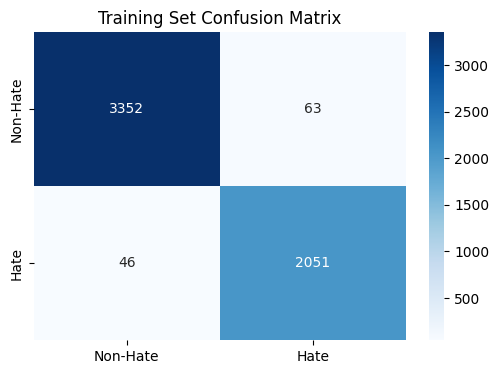


Analysis Samples:

ERROR:
Text: தமிழரிடம் மட்டுமே வரவு செலவு வைத்துக் கொள்ள வேண்டும்!
True: 0 | Predicted: 1

ERROR:
Text: Sidharukkellam sidhar, mahan, theivam, design thalivar, thivega thiruman, Aaya muthuramalinga thevar photo va vaikarathukku eethukkamattangala? 
Appo ...
True: 1 | Predicted: 0

CORRECT:
Text: தமிழ்நாட்டில் படிக்காமல் வேலை இல்லாமல் நிறைய பேர் உள்ளார்கள் இதைப் பற்றி பேச எந்த ஊடகங்களும் முன்வரவில்லை ஆனால் வட இந்தியர்கள் தற்செயலாக இறந்தாலோ அல்ல...
True: 0 | Predicted: 0

CORRECT:
Text: Some of the facts are wrong.  Better research and understanding of the historical facts are needed.
True: 0 | Predicted: 0

CORRECT:
Text: உன்னை போல் ஆக்கள் இருந்த நடக்கும் தம்பி உன்னை போல் ஆக்கள் இருந்த படியால் தான் சசிங்களவன் ஏன் தேசத்தை பிடித்தான் ஏன் தேசமே தெரியாம இருந்த சிங்கள அமியை ...
True: 1 | Predicted: 1

=== Development Set Evaluation ===



Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.93      0.91      0.92       485
        Hate       0.86      0.89      0.88       302

    accuracy                           0.90       787
   macro avg       0.89      0.90      0.90       787
weighted avg       0.90      0.90      0.90       787



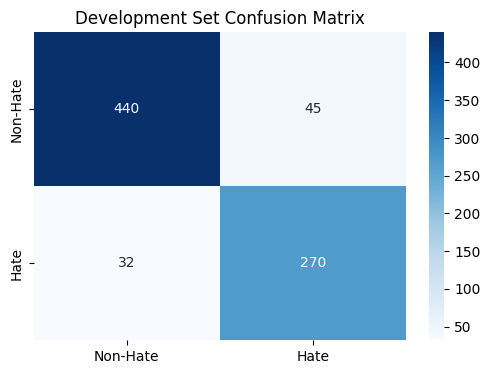


Analysis Samples:

ERROR:
Text: @TamilEelam1 ஜோக்கர், போய் உன் சுடலையை ஊம்பு 🤣🤣🤣

True: 0 | Predicted: 1

ERROR:
Text: முக்குலத்துதோர் அவ்வளவுதான் உட்பிரிவு பேசுறவனை அடி
True: 1 | Predicted: 0

CORRECT:
Text: உங்கள் ஊடகத்தை அசிங்கமாக கேட்க்க தோனது ஆனால் வேண்டாம் என்று பேசாம போறேன். இயற்கையா பிழைக்க வேற நாட்டிற்க்கு போவதும் திட்டமிட்டு தினம் தோறும் பல ஆயிரம்...
True: 1 | Predicted: 1

CORRECT:
Text: அவர்களை நாம் வடக்கன் என்று சொல்லக்கூடாது. அவர்கள் பிழைப்புக்காக வறுமையிலிருந்து தப்பிக்க முயற்சிக்கும் ஏழை புலம்பெயர்ந்த தொழிலாளர்கள்.

True: 0 | Predicted: 0

CORRECT:
Text:  @jaganerick4761  dei na ega patta north indian a pathruken da voter id la onum inga vanga matan correct a election la avan oorukku poi vote panna poi...
True: 0 | Predicted: 0

=== Test Set Evaluation ===



Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.91      0.90      0.91       970
        Hate       0.85      0.86      0.85       606

    accuracy                           0.89      1576
   macro avg       0.88      0.88      0.88      1576
weighted avg       0.89      0.89      0.89      1576



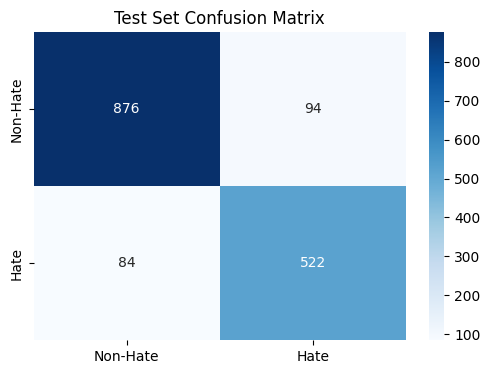


Analysis Samples:

ERROR:
Text: Holly பண்டிகை க்கு ஊருக்கு போரானுங்க திரும்பி கண்டீப்பா வருவானுங்க...
ஜல்லிக்கட்டு க்கு ஒன்று ஊடியது போல் ஓன்று கூடித்தான் ஆகனும்
True: 1 | Predicted: 0

ERROR:
Text: நாகப்பதனியா,நாகப்ப்பதனியா யார் பெரியவர் என்று பார்த்துவிடுவோம்
True: 1 | Predicted: 0

CORRECT:
Text: Nandu kadha theriyuma ? Tamizh nandu matum dhan mela yera vidama keezha thalite irundhudu.dats true
True: 0 | Predicted: 0

CORRECT:
Text: Avanunga holi festival ku poraanga yaa😂
True: 0 | Predicted: 0

CORRECT:
Text: தமிழர்களிடம் மட்டுமே வரவு செலவு வைத்துக் கொள்ள வேண்டும்!
True: 1 | Predicted: 1


In [4]:
def essential_evaluation(trainer, dataset, dataset_name):
    print(f"\n=== {dataset_name} Evaluation ===")
    
    predictions = trainer.predict(dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids
    
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=['Non-Hate', 'Hate']))
    
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Hate', 'Hate'],
                yticklabels=['Non-Hate', 'Hate'])
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()
    
    # Get texts from the original dataset (not the tokenized one)
    texts = dataset.texts if hasattr(dataset, 'texts') else [dataset[i]['text'] for i in range(len(dataset))]

    # Get indices for errors and correct predictions
    errors = np.where(preds != labels)[0]
    corrects = np.where(preds == labels)[0]

    # Random sampling without additional counts
    samples = []
    if len(errors) >= 2:
        samples.extend(np.random.choice(errors, 2, replace=False))
    if len(corrects) >= 3:
        samples.extend(np.random.choice(corrects, 3, replace=False))
    
     # Print exactly 5 samples with labels
    print("\nAnalysis Samples:")
    for idx in samples[:5]:  # Ensure we never show more than 5
        status = "ERROR" if preds[idx] != labels[idx] else "CORRECT"
        text = texts[idx][:150] + "..." if len(texts[idx]) > 150 else texts[idx]
        print(f"\n{status}:")
        print(f"Text: {text}")
        print(f"True: {labels[idx]} | Predicted: {preds[idx]}")

# Final evaluations
essential_evaluation(trainer, train_dataset, "Training Set")
essential_evaluation(trainer, dev_dataset, "Development Set")
essential_evaluation(trainer, test_dataset, "Test Set")